In [2]:
#!pip install tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.8.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import pandas as pd

df = pd.read_csv("/Pratap/Dissertation/training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')

In [4]:
df

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:
df = df.drop(columns=['id', 'date', 'query', 'user'])
df.head()

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
df = df.sample(n=20000)
df.polarity.value_counts()

0    10080
4     9920
Name: polarity, dtype: int64

In [7]:
df.isnull().sum().sort_values(ascending = False)

polarity    0
text        0
dtype: int64

Text(0.5, 1.0, 'Sentiment Data Distribution')

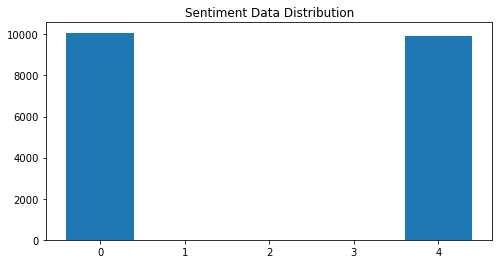

In [8]:
val_count = df.polarity.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [9]:
df.polarity = df.polarity.replace({0: 0, 4: 1})
df.polarity.value_counts()

0    10080
1     9920
Name: polarity, dtype: int64

In [10]:
stop_words = stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [11]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip() #lower case
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [12]:
df.text = df.text.apply(lambda x: preprocess(x))

In [13]:
import os

In [14]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [19]:
#train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         #random_state=7) # Splits Dataset into Training and Testing set

X_data, y_data = np.array(df['text']), np.array(df['polarity'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size = 1-TRAIN_SIZE, random_state = 0)
print('Data Split done.')
#("Train Data size:", len(train_data))
#print("Test Data size", len(test_data))

Data Split done.


In [20]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [21]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 3066
Wall time: 891 ms


In [22]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [24]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (16000, 60)
X_test.shape : (4000, 60)


In [25]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


In [27]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

In [31]:
from tensorflow.keras import Sequential
model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

In [34]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                        

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [37]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
history = model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
16/16 [==============================] - 96s 6s/step - loss: 0.6921 - accuracy: 0.5227 - val_loss: 0.6935 - val_accuracy: 0.5006 - lr: 0.0010
Epoch 2/12
16/16 [==============================] - 94s 6s/step - loss: 0.6915 - accuracy: 0.5216 - val_loss: 0.6961 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 3/12
16/16 [==============================] - 97s 6s/step - loss: 0.6925 - accuracy: 0.5109 - val_loss: 0.6941 - val_accuracy: 0.4931 - lr: 0.0010
Epoch 4/12
16/16 [==============================] - 111s 7s/step - loss: 0.6914 - accuracy: 0.5202 - val_loss: 0.6913 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 5/12
16/16 [==============================] - 111s 7s/step - loss: 0.6909 - accuracy: 0.5238 - val_loss: 0.7020 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 6/12
16/16 [==============================] - 103s 6s/step - loss: 0.6910 - accuracy: 0.5256 - val_loss: 0.6917 - val_accuracy: 0.5169 - lr: 0.0010
Epoch 7/12
16/16 [==============================] - 108s 7s/step - loss: 0.6913

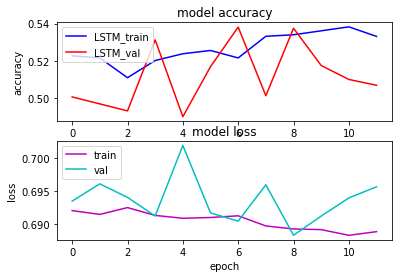

In [42]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')